In [84]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

import math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

# Gradient-free `CRP` parameter optimization

## 1. Set up small demo circuit

In [87]:
dev = qml.device("default.qubit", wires=4, shots=None)

@qml.qnode(dev)
def complex_circuit(crx_param):
    # some unparameterized gates
    qml.Hadamard(wires=0)
    qml.RX(1.2, wires=1)
    qml.Hadamard(wires=1)
    qml.CRX(math.pi/2, wires=[1, 0])

    # this is the gate to optimize
    qml.CRX(crx_param, wires=[0, 1])

    # some more unparameterized gates 
    qml.RX(2.3, wires=0)
    qml.CNOT(wires=[1, 0])
    
    # measure qubit 0 in computational basis
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev)
def rx_circuit(rx_param):
    qml.RX(rx_param, wires=0)

    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def crx_circuit(crx_param):
    qml.Hadamard(wires=0)
    qml.CRX(crx_param, wires=[0, 1])

    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev)
def xxx_circuit(crz_param):
    num_layers = 5
    num_qubits = 4
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            qml.RX(1, wires=qubit) # params[layer, qubit, 0]
            qml.RZ(1, wires=qubit) # params[layer, qubit, 1]
        for qubit in range(num_qubits - 2, -1, -1): # incl. start, excl. stop, step
            qml.CRZ(crz_param if layer == 1 and qubit == 0 else 1, (qubit + 1, qubit)) # params[layer, qubit, 2]
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev)
def an_interesting_circuit(params: NDArray[np.float_]):
    num_layers = 5
    num_qubits = 4
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RZ(params[layer, qubit, 1], wires=qubit)
        for qubit in range(num_qubits - 2, -1, -1): # incl. start, excl. stop, step
            qml.CRZ(params[layer, qubit, 2], (qubit + 1, qubit))
    return qml.expval(qml.PauliZ(1))

circuit = xxx_circuit
print(qml.draw(circuit)((0,)))

0: ──RX(1.00)──RZ(1.00)─────────────────────╭RZ(1.00)──RX(1.00)──RZ(1.00)───────────╭RZ(M0)──
1: ──RX(1.00)──RZ(1.00)───────────╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●───────
2: ──RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)
3: ──RX(1.00)──RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)───────────╰●─────────RX(1.00)──RZ(1.00)

───RX(1.00)──RZ(1.00)───────────╭RZ(1.00)──RX(1.00)──RZ(1.00)───────────╭RZ(1.00)──RX(1.00)
───RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)
───RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)
────────────╰●─────────RX(1.00)──RZ(1.00)───────────╰●─────────RX(1.00)──RZ(1.00)──────────

───RZ(1.00)───────────╭RZ(1.00)─┤     
───RZ(1.00)─╭RZ(1.00)─╰●────────┤  <Z>
──╭RZ(1.00)─╰●──────────────────┤     
──╰●────────────────────────────┤     
M0 = 
[0]


## 2. Reconstruct cost function

In [79]:
def reconstruct(original_function, theta = 0, debug = False):

    # measure function at six chosen points
    y_0 = original_function(theta + 0)
    if debug: print(f"y_0={y_0}")

    y_pi = original_function(theta + math.pi)
    if debug: print(f"y_pi={y_pi}")

    y_32pi = original_function(theta + 3 / 2 * math.pi)
    if debug: print(f"y_3/2pi={y_32pi}")

    y_2pi = original_function(theta + 2 * math.pi)
    if debug: print(f"y_2pi={y_2pi}")

    y_3pi = original_function(theta + 3 * math.pi)
    if debug: print(f"y_3pi={y_3pi}")

    y_72pi = original_function(theta + 7 / 2 * math.pi)
    if debug: print(f"y_7/2pi={y_72pi}\n")


    # determine reconstruction constants from these measurements
    d1 = (1/4) * (y_0 + y_2pi + y_pi + y_3pi)
    if debug: print(f"d_1={d1}")

    y1_0 = (1/2) * (y_0 - y_2pi)
    y1_3pi = (1/2) * (y_3pi - y_pi)
    if y1_0 == 0 and y1_3pi == 0:
        d2 = 0 # arbitrary choice
        d3 = 0
    elif y1_0 == 0 and y1_3pi != 0:
        d2 = (1/2) * math.pi - theta / 2
        d3 = y1_3pi
    else:
        d2 = math.atan(y1_3pi / y1_0) - theta / 2
        d3 = y1_0 / math.cos(theta / 2 + d2)
    if debug: print(f"d_2={d2}\nd_3={d3}")

    y2_0 = (1/2) * (y_0 + y_2pi - 2 * d1)
    y2_32pi = (1/2) * (y_32pi + y_72pi - 2 * d1)
    if y2_0 == 0 and y2_32pi == 0:
        d4 = 0 # arbitrary choice
        d5 = 0
    elif y2_0 == 0 and y2_32pi != 0:
        d4 = (1/2) * math.pi - theta
        d5 = y2_32pi
    else:
        d4 = math.atan(y2_32pi / y2_0) - theta
        d5 = y2_0 / math.cos(theta + d4)
    if debug: print(f"d_4={d4}\nd_5={d5}\n")


    # and finally, reconstruct the cost function
    def reconstructed_function(theta):
        return d1 + d3 * math.cos(theta / 2 + d2) + d5 * math.cos(theta + d4)
    
    return reconstructed_function

reconstruction = reconstruct(circuit, debug=True)

y_0=0.5326850642341028
y_pi=-0.047017362178458866
y_3/2pi=-0.33898265090232516
y_2pi=-0.2592447705221337
y_3pi=-0.4392243085543897
y_7/2pi=-0.05633588593313782

d_1=-0.05320034425521987
d_2=-0.45984414119202066
d_3=0.44186512420719865
d_4=-0.6502686716968427
d_5=0.238617211688745



## 3. Find optimal parameter

In [99]:
def minimize_reconstruction(reconstruction, x0 = math.pi, debug = False):
    x0 = math.pi
    res = minimize(reconstruction, x0, method='Nelder-Mead', tol=1e-6)

    if debug: print(res)
    return res.x[0], res.fun

numerical_x, _ = minimize_reconstruction(reconstruction, debug=True)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.3400619091520473
             x: [ 4.825e+00]
           nit: 24
          nfev: 48
 final_simplex: (array([[ 4.825e+00],
                       [ 4.825e+00]]), array([-3.401e-01, -3.401e-01]))


## 4. Optimization loop

In [89]:
def create_univariate(circuit, params: NDArray[np.int_], param_index):
    def univariate(param_value):
        updated_params = params.copy()
        updated_params[param_index] = param_value
        return circuit(updated_params)
    
    return univariate

In [111]:

# in each iteration, reconstruct and optimize the univariate cost functions independently
def crotosolve_iteration(circuit, params, debug = False):
    final_value = 42

    iterator = np.nditer(params, flags=['multi_index'])
    for old_param_value in iterator:
        param_index = iterator.multi_index
        if debug: print(f"Optimizing parameter {param_index}...")
        univariate = create_univariate(circuit, params, param_index)
        reconstruction = reconstruct(univariate)
        new_param_value, new_fun_value = minimize_reconstruction(reconstruction)
        if debug: print(f"Parameter update for {param_index} from {old_param_value} to {new_param_value} ({new_fun_value})")
        params[param_index] = new_param_value
        final_value = new_fun_value
    
    return final_value

In [112]:
def crotosolve(circuit, initial_params, debug = False):
    dataset = []

    params = initial_params.copy()
    for iteration in range(5):
        if debug: print(f" ===== ITERATION NO {iteration} =====")
        new_fun_value = crotosolve_iteration(circuit, params, debug=debug)
        dataset.append(new_fun_value)
    
    if debug: print(dataset)
    return params

rng = np.random.default_rng()
params = rng.random((5, 4, 3))

crotosolve(an_interesting_circuit, params, debug=True)

 ===== ITERATION NO 0 =====
Optimizing parameter (0, 0, 0)...
Parameter update for (0, 0, 0) from 0.9009578201789059 to 5.2416447096124745 (-0.017488235903954708)
Optimizing parameter (0, 0, 1)...
Parameter update for (0, 0, 1) from 0.869462706239676 to 6.029919086987206 (-0.14148881645190026)
Optimizing parameter (0, 0, 2)...
Parameter update for (0, 0, 2) from 0.13522253231600023 to 1.1864969883323369 (-0.18741026710973469)
Optimizing parameter (0, 1, 0)...
Parameter update for (0, 1, 0) from 0.5939552791933905 to 1.9426656271856206 (-0.7467296345527964)
Optimizing parameter (0, 1, 1)...
Parameter update for (0, 1, 1) from 0.424462632294315 to 6.159987475152513 (-0.8533894829195994)
Optimizing parameter (0, 1, 2)...
Parameter update for (0, 1, 2) from 0.8036593063214394 to 9.5583625205219 (-0.9292202802705893)
Optimizing parameter (0, 2, 0)...
Parameter update for (0, 2, 0) from 0.2225311342921521 to 0.45794899182967397 (-0.9460622745947315)
Optimizing parameter (0, 2, 1)...
Paramete

tensor([[[ 5.5034413 ,  6.09578079,  1.23479821],
         [ 1.92759906,  6.14322993,  7.03899262],
         [ 0.44644054,  0.34910527,  6.24893859],
         [ 3.25048611,  6.23081904,  3.14159265]],

        [[ 1.1548868 ,  0.64788098,  0.474048  ],
         [ 0.67066539,  0.15800781, -0.18880667],
         [ 0.60170516,  0.68840444,  0.15151356],
         [ 6.3596135 ,  0.19657964,  3.14159265]],

        [[ 0.88298451,  5.50886596,  0.73273409],
         [ 0.27106759,  0.80395873,  0.65229777],
         [ 0.93089804,  4.42178171,  0.4857506 ],
         [ 6.30897776,  2.98451302,  3.14159265]],

        [[ 0.49377883,  3.29867229,  0.43163703],
         [ 0.34006377,  0.21593536,  0.30835531],
         [ 2.56940404,  3.14159265,  3.14159265],
         [ 3.14159265,  2.98451302,  3.14159265]],

        [[ 3.14159265,  3.14159265,  3.29867229],
         [ 0.3645769 ,  3.29867229,  3.14159265],
         [ 3.29867229,  3.14159265,  3.14159265],
         [ 3.14159265,  3.14159265,  3.141

## 4. Compare reconstruction with circuit

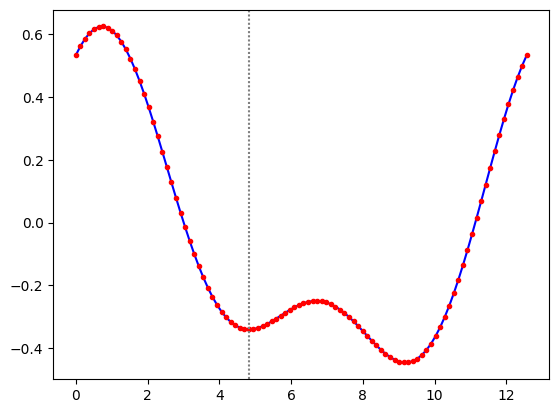

In [100]:
# initialize crx_param with 0.5 but could be any value
initial_param = (0.5,)

param = initial_param

param_values = np.linspace(0, 4 * math.pi, 100)
results = [float(circuit(p)) for p in param_values]
reconstructed_results = [reconstruction(p) for p in param_values]

fig, ax = plt.subplots()
ax.plot(param_values, results, 'b')
ax.plot(param_values, reconstructed_results, 'r.')
ax.axvline(x=numerical_x, dashes=(True,), color='gray')